In [1]:
# =========================================================
# SEÇÃO 1: IMPORTAÇÕES E SETUP GERAL
# =========================================================

In [2]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools

# Libs de Modelagem e Estatística
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.datasets import get_rdataset
from dieboldmariano import dm_test
import pmdarima as pm
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, MLP, LSTM, Autoformer, NHITS

# Libs de Avaliação
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from IPython.display import display, Markdown

warnings.filterwarnings("ignore")

In [3]:
# =========================================================
# SEÇÃO 2: FUNÇÕES AUXILIARES (SETUP E PROCESSAMENTO)
# =========================================================

In [4]:
def definir_seed(seed_value=42):
    np.random.seed(seed_value)
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

In [5]:
def salvar_dataset(serie, dataset_name):
    dir_path = "./data/bronze"
    os.makedirs(dir_path, exist_ok=True)
    file_path = os.path.join(dir_path, f"{dataset_name.lower()}.csv")
    df = pd.DataFrame({"date": serie.index, "value": serie.values})
    df.to_csv(file_path, index=False)
    print(f"-> Cópia do dataset '{dataset_name}' salva em: {file_path}")

def carregar_serie(nome):
    print(f"Buscando dados de '{nome}' via statsmodels...")
    nome_base = nome.lower()

    if nome_base == "airpassengers":
        df = get_rdataset("AirPassengers", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1949-01-01", periods=len(df), freq="MS"),
                          name="AirPassengers")
    elif nome_base == "lynx":
        df = get_rdataset("lynx", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1821", periods=len(df), freq="A"), name="Lynx")
    elif nome_base == "co2":
        df = get_rdataset("CO2", package="datasets").data
        df = df.ffill()
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1958-03-29", periods=len(df), freq="MS"),
                          name="CO2")
    elif nome_base == "sunspots":
        df = get_rdataset("sunspots", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1749-01-01", periods=len(df), freq="MS"),
                          name="Sunspots")
    elif nome_base == "austres":
        df = get_rdataset("austres", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1971-03-01", periods=len(df), freq="QS-MAR"),
                          name="AustralianResidents")
    elif nome_base == "nottem":
        df = get_rdataset("nottem", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1920-01-01", periods=len(df), freq="MS"),
                          name="Nottingham")
    else:
        raise ValueError(f"Lógica de download para a série '{nome}' não implementada.")

    salvar_dataset(serie, nome)
    return serie

In [6]:
def dividir_serie_temporal(serie, percentual_treino=0.85):
    tamanho_total = len(serie)
    ponto_corte_treino = int(tamanho_total * percentual_treino)
    treino = serie.iloc[:ponto_corte_treino]
    teste = serie.iloc[ponto_corte_treino:]
    return treino, teste

def preparar_dados_para_neuralforecast(serie, nome_serie):
    df = serie.reset_index()
    df.columns = ['ds', 'y']
    df['unique_id'] = nome_serie
    return df

In [7]:
# =========================================================
# SEÇÃO 3: FUNÇÕES PARA CÁLCULO DE MÉTRICAS E MODELAGEM
# =========================================================

In [8]:
def calcular_metricas(y_true, y_pred, y_train):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else np.inf
    n = len(y_train)
    d = np.sum(np.abs(y_train[1:] - y_train[:-1])) / (n - 1) if n > 1 else np.nan
    mase = np.mean(np.abs(y_true - y_pred)) / d if d is not np.nan and d > 0 else np.inf
    return {'RMSE': rmse, 'MAPE(%)': mape, 'MASE': mase}

In [9]:
# =========================================================
# SEÇÃO 4: PIPELINE AVANÇADO PARA O ARIMA
# =========================================================


In [10]:
def encontrar_melhor_arima_auto(treino_log, freq):
    """Usa auto_arima para encontrar a melhor ordem ARIMA, incluindo sazonalidade."""
    print("Buscando melhor ordem ARIMA com auto_arima...")
    m = 12 if freq.startswith('M') else (4 if freq.startswith('Q') else 1)
    auto_arima_model = pm.auto_arima(treino_log, m=m, seasonal=True, trace=False, error_action='ignore', suppress_warnings=True, stepwise=True)
    print(f"Melhor ordem encontrada: {auto_arima_model.order} Sazonal: {auto_arima_model.seasonal_order}")
    return auto_arima_model.order, auto_arima_model.seasonal_order

In [11]:
# =========================================================
# SEÇÃO 5: PIPELINE DE EXPERIMENTO COMPLETO E AVANÇADO
# =========================================================

In [12]:
def executar_experimento(nome_da_serie, horizonte):
    """Executa o pipeline completo com as correções de estabilidade."""
    try:
        SEED = 42; definir_seed(SEED)
        MAX_INPUT_SIZE = 24; MAX_STEPS_NEURAL = 150
        
        serie_original = carregar_serie(nome_da_serie)
        
        percentual_treino = 1 - (horizonte / len(serie_original))
        if percentual_treino < 0.5: # Garante pelo menos 50% de dados para treino
             print(f"AVISO: Horizonte {horizonte} é muito grande para a série '{nome_da_serie}'. Pulando.")
             return None
        
        treino_orig, teste_orig = dividir_serie_temporal(serie_original, percentual_treino=percentual_treino)
        serie_log = np.log(serie_original)
        treino_log, _ = dividir_serie_temporal(serie_log, percentual_treino=percentual_treino)
        
        freq = serie_original.index.freqstr or pd.infer_freq(serie_original.index)
        if freq is None: return None

        previsoes_teste = {'y_true': teste_orig.values}
        
        # --- 1. Modelo ARIMA ---
        modelo_arima = None
        try:
            print("Processando: ARIMA")
            ordem, ordem_sazonal = encontrar_melhor_arima_auto(treino_log, freq)
            modelo_arima = ARIMA(treino_log.asfreq(freq), order=ordem, seasonal_order=ordem_sazonal).fit()
            # CORREÇÃO: Usando .forecast() para previsão out-of-sample
            preds_log_teste_arima = modelo_arima.forecast(steps=horizonte)
            previsoes_teste['ARIMA'] = np.exp(preds_log_teste_arima).values
        except Exception as e: print(f"AVISO: ARIMA falhou: {e}")

        # --- 2. Modelos Neurais Puros ---
        df_treino_log_nf = preparar_dados_para_neuralforecast(treino_log, nome_da_serie)
        modelos_para_testar = {'N-BEATS': NBEATS, 'MLP': MLP, 'LSTM': LSTM, 'Autoformer': Autoformer, 'NHITS': NHITS}
        
        for nome_modelo, classe_modelo in modelos_para_testar.items():
            try:
                print(f"Processando: {nome_modelo}")
                # CORREÇÃO: Removida a configuração de arquitetura customizada para N-BEATS/NHITS
                modelo_neural = [classe_modelo(input_size=min(2 * horizonte, MAX_INPUT_SIZE), h=horizonte, max_steps=MAX_STEPS_NEURAL, scaler_type='standard', random_seed=SEED)]
                nf = NeuralForecast(models=modelo_neural, freq=freq)
                nf.fit(df=df_treino_log_nf, verbose=False)
                previsoes_teste[nome_modelo] = np.exp(nf.predict()[classe_modelo.__name__].values)
            except Exception as e: print(f"AVISO: {nome_modelo} falhou: {e}")
        
        # --- 3. Modelo Híbrido (MIMO) ---
        if 'ARIMA' in previsoes_teste and modelo_arima is not None:
            try:
                print("Processando: Híbrido (MIMO)")
                residuos_treino_log = modelo_arima.resid
                df_residuos_nf = preparar_dados_para_neuralforecast(residuos_treino_log, "residuos")
                modelo_residuos = [NBEATS(input_size=min(2*horizonte, MAX_INPUT_SIZE), h=horizonte, max_steps=MAX_STEPS_NEURAL, scaler_type='standard', random_seed=SEED)]
                nf_residuos = NeuralForecast(models=modelo_residuos, freq=freq)
                nf_residuos.fit(df=df_residuos_nf, verbose=False)
                preds_residuos_log = nf_residuos.predict()['NBEATS'].values
                previsoes_teste['Híbrido (MIMO)'] = previsoes_teste['ARIMA'] + preds_residuos_log
            except Exception as e: print(f"AVISO: Híbrido (MIMO) falhou: {e}")
            
        df_final = pd.DataFrame(previsoes_teste, index=teste_orig.index)
        df_final['dataset'] = nome_da_serie
        df_final['horizonte'] = horizonte
        return df_final.reset_index().rename(columns={'index': 'ds'})
    except Exception as e:
        print(f"ERRO GERAL no processamento de '{nome_da_serie}' para o horizonte {horizonte}: {e}")

In [13]:
# =========================================================
# SEÇÃO 6: ORQUESTRADOR
# =========================================================

In [25]:
LISTA_DE_DATASETS = ['AirPassengers', 'co2'] 
VETOR_DE_HORIZONTES = [12, 24]
resultados_gerais = []
output_dir = "./data/silver"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "resultados_completos.csv")

In [ ]:
for dataset in tqdm(LISTA_DE_DATASETS, desc="Processando Datasets"):
    for horizonte in tqdm(VETOR_DE_HORIZONTES, desc=f"Testando Horizontes para {dataset}", leave=False):
        df_resultado_detalhado = executar_experimento(dataset, horizonte)
        if df_resultado_detalhado is not None:
            resultados_gerais.append(df_resultado_detalhado)

Processando Datasets:   0%|          | 0/2 [00:00<?, ?it/s]

Buscando dados de 'AirPassengers' via statsmodels...
-> Cópia do dataset 'AirPassengers' salva em: ./data/bronze\airpassengers.csv
Processando: ARIMA
Buscando melhor ordem ARIMA com auto_arima...
Melhor ordem encontrada: (2, 0, 0) Sazonal: (0, 1, 1, 12)


Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Processando: N-BEATS



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
900       Non-trainable params
2.4 M     Total params
9.789     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s, v_num=0, train_loss_step=0.0372, train_loss_epoch=0.0372]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s, v_num=0, train_loss_step=0.0372, train_loss_epoch=0.0372]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.58it/s]
Processando: MLP


Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | mlp          | ModuleList    | 1.1 M  | train
4 | out          | Linear        | 12.3 K | train
-------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.350     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s, v_num=2, train_loss_step=0.0705, train_loss_epoch=0.0705]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.48it/s, v_num=2, train_loss_step=0.0705, train_loss_epoch=0.0705]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.78it/s] 

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 24.1 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
510 K     Trainable params
0         Non-trainable params
510 K     Total params
2.042     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode



Processando: LSTM
Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 22.89it/s, v_num=4, train_loss_step=0.331, train_loss_epoch=0.331]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 20.05it/s, v_num=4, train_loss_step=0.331, train_loss_epoch=0.331]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.27it/s]
Processando: Autoformer


Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 148 K  | train
7 | decoder       | Decoder       | 141 K  | train
--------------------------------------------------------
290 K     Trainable params
0         Non-trainable params
290 K     Total params
1.162     Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


Epoch 149: 100%|██████████| 1/1 [00:03<00:00,  0.31it/s, v_num=6, train_loss_step=0.390, train_loss_epoch=0.390]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:03<00:00,  0.31it/s, v_num=6, train_loss_step=0.390, train_loss_epoch=0.390]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.751     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode



Processando: NHITS
Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s, v_num=8, train_loss_step=0.0618, train_loss_epoch=0.0618]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s, v_num=8, train_loss_step=0.0618, train_loss_epoch=0.0618]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.94it/s] 
Processando: Híbrido (MIMO)


Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
900       Non-trainable params
2.4 M     Total params
9.789     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s, v_num=10, train_loss_step=0.0121, train_loss_epoch=0.0121]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s, v_num=10, train_loss_step=0.0121, train_loss_epoch=0.0121]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.75it/s] 


Buscando dados de 'AirPassengers' via statsmodels...
-> Cópia do dataset 'AirPassengers' salva em: ./data/bronze\airpassengers.csv
Processando: ARIMA
Buscando melhor ordem ARIMA com auto_arima...
Melhor ordem encontrada: (2, 0, 0) Sazonal: (0, 1, 1, 12)


Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
2.4 K     Non-trainable params
2.5 M     Total params
9.918     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Processando: N-BEATS
Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, v_num=12, train_loss_step=0.0408, train_loss_epoch=0.0408]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s, v_num=12, train_loss_step=0.0408, train_loss_epoch=0.0408]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.45it/s]

Seed set to 42



Processando: MLP


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | mlp          | ModuleList    | 1.1 M  | train
4 | out          | Linear        | 24.6 K | train
-------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.399     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s, v_num=14, train_loss_step=0.0851, train_loss_epoch=0.0851]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.40it/s, v_num=14, train_loss_step=0.0851, train_loss_epoch=0.0851]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.71it/s] 

Seed set to 42



Processando: LSTM


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 48.2 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
534 K     Trainable params
0         Non-trainable params
534 K     Total params
2.139     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 27.98it/s, v_num=16, train_loss_step=0.289, train_loss_epoch=0.289]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 24.11it/s, v_num=16, train_loss_step=0.289, train_loss_epoch=0.289]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.85it/s]
Processando: Autoformer


Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 148 K  | train
7 | decoder       | Decoder       | 141 K  | train
--------------------------------------------------------
290 K     Trainable params
0         Non-trainable params
290 K     Total params
1.162     Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


Epoch 149: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=18, train_loss_step=0.501, train_loss_epoch=0.501]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=18, train_loss_step=0.501, train_loss_epoch=0.501]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]

Seed set to 42



Processando: NHITS


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.794     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s, v_num=20, train_loss_step=0.0761, train_loss_epoch=0.0761]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s, v_num=20, train_loss_step=0.0761, train_loss_epoch=0.0761]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.47it/s]


Seed set to 42


Processando: Híbrido (MIMO)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
2.4 K     Non-trainable params
2.5 M     Total params
9.918     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s, v_num=22, train_loss_step=0.0121, train_loss_epoch=0.0121]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s, v_num=22, train_loss_step=0.0121, train_loss_epoch=0.0121]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.54it/s]


Processando Datasets:  50%|█████     | 1/2 [29:43<29:43, 1783.42s/it]

Buscando dados de 'co2' via statsmodels...
-> Cópia do dataset 'co2' salva em: ./data/bronze\co2.csv
Processando: ARIMA
Buscando melhor ordem ARIMA com auto_arima...
Melhor ordem encontrada: (3, 1, 2) Sazonal: (2, 0, 2, 12)


Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
900       Non-trainable params
2.4 M     Total params
9.789     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Processando: N-BEATS
Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s, v_num=24, train_loss_step=0.137, train_loss_epoch=0.137]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s, v_num=24, train_loss_step=0.137, train_loss_epoch=0.137]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.88it/s]

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | mlp          | ModuleList    | 1.1 M  | train
4 | out          | Linear        | 12.3 K | train
-------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.350     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode



Processando: MLP
Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.21it/s, v_num=26, train_loss_step=0.138, train_loss_epoch=0.138]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  6.91it/s, v_num=26, train_loss_step=0.138, train_loss_epoch=0.138]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.63it/s]

Seed set to 42



Processando: LSTM


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 24.1 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
510 K     Trainable params
0         Non-trainable params
510 K     Total params
2.042     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 14.62it/s, v_num=28, train_loss_step=0.198, train_loss_epoch=0.198]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s, v_num=28, train_loss_step=0.198, train_loss_epoch=0.198]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 148 K  | train
7 | decoder       | Decoder       | 141 K  | train
--------------------------------------------------------
290 K     Trainable params
0         Non-trainable params
290 K     Total params
1.162     Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode



Processando: Autoformer
Epoch 149: 100%|██████████| 1/1 [00:03<00:00,  0.28it/s, v_num=30, train_loss_step=0.273, train_loss_epoch=0.273]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:03<00:00,  0.28it/s, v_num=30, train_loss_step=0.273, train_loss_epoch=0.273]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.90it/s]

Seed set to 42



Processando: NHITS


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.751     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s, v_num=32, train_loss_step=0.149, train_loss_epoch=0.149]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s, v_num=32, train_loss_step=0.149, train_loss_epoch=0.149]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.64it/s]

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Processando: Híbrido (MIMO)



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
900       Non-trainable params
2.4 M     Total params
9.789     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s, v_num=34, train_loss_step=0.0439, train_loss_epoch=0.0439]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s, v_num=34, train_loss_step=0.0439, train_loss_epoch=0.0439]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.82it/s]


Buscando dados de 'co2' via statsmodels...
-> Cópia do dataset 'co2' salva em: ./data/bronze\co2.csv
Processando: ARIMA
Buscando melhor ordem ARIMA com auto_arima...
Melhor ordem encontrada: (3, 1, 1) Sazonal: (2, 0, 2, 12)


Seed set to 42


Processando: N-BEATS


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
2.4 K     Non-trainable params
2.5 M     Total params
9.918     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s, v_num=36, train_loss_step=0.176, train_loss_epoch=0.176]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s, v_num=36, train_loss_step=0.176, train_loss_epoch=0.176]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.54it/s]


Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | mlp          | ModuleList    | 1.1 M  | train
4 | out          | Linear        | 24.6 K | train
-------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.399     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Processando: MLP
Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.97it/s, v_num=38, train_loss_step=0.188, train_loss_epoch=0.188]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.60it/s, v_num=38, train_loss_step=0.188, train_loss_epoch=0.188]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.41it/s] 
Processando: LSTM


Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 48.2 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
534 K     Trainable params
0         Non-trainable params
534 K     Total params
2.139     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 22.67it/s, v_num=40, train_loss_step=0.601, train_loss_epoch=0.601]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s, v_num=40, train_loss_step=0.601, train_loss_epoch=0.601]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.78it/s]

Seed set to 42



Processando: Autoformer


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 148 K  | train
7 | decoder       | Decoder       | 141 K  | train
--------------------------------------------------------
290 K     Trainable params
0         Non-trainable params
290 K     Total params
1.162     Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


Epoch 149: 100%|██████████| 1/1 [00:04<00:00,  0.22it/s, v_num=42, train_loss_step=0.357, train_loss_epoch=0.357]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:04<00:00,  0.22it/s, v_num=42, train_loss_step=0.357, train_loss_epoch=0.357]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.58it/s]

Seed set to 42



Processando: NHITS


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.794     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s, v_num=44, train_loss_step=0.197, train_loss_epoch=0.197]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s, v_num=44, train_loss_step=0.197, train_loss_epoch=0.197]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.13it/s]

Seed set to 42



Processando: Híbrido (MIMO)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
2.4 K     Non-trainable params
2.5 M     Total params
9.918     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s, v_num=46, train_loss_step=0.0411, train_loss_epoch=0.0411]

`Trainer.fit` stopped: `max_steps=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s, v_num=46, train_loss_step=0.0411, train_loss_epoch=0.0411]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.67it/s]


Processando Datasets: 100%|██████████| 2/2 [1:02:45<00:00, 1882.70s/it]


In [15]:
if resultados_gerais:
    df_final = pd.concat(resultados_gerais)
    df_final.to_csv(output_file, index=False)
    print(f"\nArquivo '{output_file}' salvo com sucesso!")


Arquivo './data/silver\resultados_completos.csv' salvo com sucesso!


In [16]:
# =========================================================
# SEÇÃO 7: GERAÇÃO DE RELATÓRIOS A PARTIR DOS ARQUIVOS SALVOS
# =========================================================



     GERANDO SUÍTE COMPLETA DE RELATÓRIOS
Buscando dados de 'AirPassengers' via statsmodels...
-> Cópia do dataset 'AirPassengers' salva em: ./data/bronze\airpassengers.csv
Buscando dados de 'co2' via statsmodels...
-> Cópia do dataset 'co2' salva em: ./data/bronze\co2.csv

--- RELATÓRIO 1: EVOLUÇÃO DO ERRO (RMSE) POR HORIZONTE ---


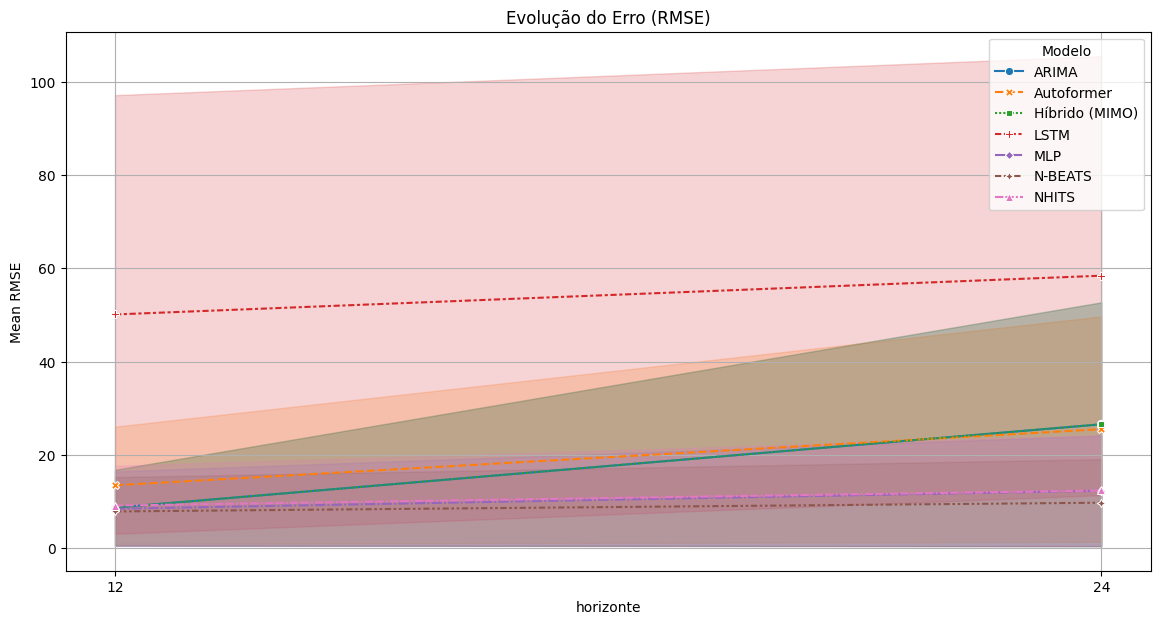


--- RELATÓRIO 2: DESEMPENHO GERAL (MÉDIA EM TODOS CENÁRIOS) ---


,Mean RMSE,Mean MAPE(%),Mean MASE
Modelo,,,
ARIMA,17.583,3.302,0.855
Autoformer,19.465,3.228,1.008
Híbrido (MIMO),17.587,3.304,0.855
LSTM,54.259,8.353,4.928
MLP,10.337,1.910,0.544
N-BEATS,8.765,1.574,0.476
NHITS,10.707,1.887,0.577



--- RELATÓRIO 3: DESEMPENHO DETALHADO (HORIZONTE MAIS LONGO: 24) ---



--- RELATÓRIO 4: RANKING DOS MODELOS (BASEADO EM RMSE, HORIZONTE 24) ---


Modelo,ARIMA,Autoformer,Híbrido (MIMO),LSTM,MLP,N-BEATS,NHITS
dataset,,,,,,,
AirPassengers,5.0,4.0,6.0,7.0,2.0,1.0,3.0
co2,2.0,6.0,3.0,7.0,5.0,1.0,4.0
Média do Rank,3.5,5.0,4.5,7.0,3.5,1.0,3.5



--- RELATÓRIO 5: TESTE DE HIPÓTESE (p-valor, HORIZONTE MAIS LONGO) ---


,ARIMA,N-BEATS,MLP,LSTM,Autoformer,NHITS
dataset,,,,,,
AirPassengers,0.003,0.000,0.000,0.013,0.765,0.000
co2,0.153,0.974,0.286,0.000,0.006,0.502


In [44]:
print("\n\n" + "="*60); print("     GERANDO SUÍTE COMPLETA DE RELATÓRIOS"); print("="*60)
try:
    df_results = pd.read_csv(output_file)
    modelos = [col for col in df_results.columns if col not in ['ds', 'y_true', 'dataset', 'horizonte']]
    
    y_train_dict = {dataset: dividir_serie_temporal(carregar_serie(dataset))[0].values for dataset in df_results['dataset'].unique()}
    
    df_melted = df_results.melt(id_vars=['ds', 'y_true', 'dataset', 'horizonte'], value_vars=modelos, var_name='Modelo', value_name='y_pred')
    
    metricas_gerais = []
    for (dataset, horizonte, modelo), group in df_melted.groupby(['dataset', 'horizonte', 'Modelo']):
        if not group['y_pred'].isnull().all():
            metricas = calcular_metricas(group['y_true'], group['y_pred'], y_train_dict[dataset])
            metricas['dataset'], metricas['horizonte'], metricas['Modelo'] = dataset, horizonte, modelo
            metricas_gerais.append(metricas)
    
    df_metricas_final = pd.DataFrame(metricas_gerais)
    rename_dict = {'RMSE': 'Mean RMSE', 'MAPE(%)': 'Mean MAPE(%)', 'MASE': 'Mean MASE'}
    df_metricas_final.rename(columns=rename_dict, inplace=True)

    # --- Relatório 1: Evolução do Erro por Horizonte ---
    print("\n--- RELATÓRIO 1: EVOLUÇÃO DO ERRO (RMSE) POR HORIZONTE ---")
    plt.figure(figsize=(14, 7)); sns.lineplot(data=df_metricas_final, x='horizonte', y='Mean RMSE', hue='Modelo', style='Modelo', markers=True); plt.title("Evolução do Erro (RMSE)"); plt.grid(True); plt.xticks(VETOR_DE_HORIZONTES); plt.show()

    # --- Relatório 2: Desempenho Geral Agregado ---
    print("\n--- RELATÓRIO 2: DESEMPENHO GERAL (MÉDIA EM TODOS CENÁRIOS) ---")
    df_agrupado = df_metricas_final.groupby('Modelo')[['Mean RMSE', 'Mean MAPE(%)', 'Mean MASE']].mean()
    display(df_agrupado.style.format('{:.3f}').highlight_min(axis=0, props='background-color: #4285F4; color: white;'))

    # --- Relatório 3: Desempenho Detalhado (foco no maior horizonte) ---
    maior_horizonte = df_metricas_final['horizonte'].max()
    print(f"\n--- RELATÓRIO 3: DESEMPENHO DETALHADO (HORIZONTE MAIS LONGO: {int(maior_horizonte)}) ---")
    df_detalhado = df_metricas_final[df_metricas_final['horizonte'] == maior_horizonte].pivot_table(index='dataset', columns='Modelo', values=['Mean RMSE', 'Mean MAPE(%)', 'Mean MASE'])
    display(df_detalhado.style.format('{:.3f}'))

    # --- Relatório 4: Ranking (foco no maior horizonte) ---
    print(f"\n--- RELATÓRIO 4: RANKING DOS MODELOS (BASEADO EM RMSE, HORIZONTE {int(maior_horizonte)}) ---")
    df_rank = df_metricas_final[df_metricas_final['horizonte'] == maior_horizonte]
    df_rank['Rank'] = df_rank.groupby('dataset')['Mean RMSE'].rank().astype(int)
    df_pivot_rank = df_rank.pivot_table(index='dataset', columns='Modelo', values='Rank')
    if len(df_pivot_rank) > 1: df_pivot_rank.loc['Média do Rank'] = df_pivot_rank.mean(axis=0)
    display(df_pivot_rank.style.format('{:.1f}').highlight_min(axis=1, props='background-color: #4285F4; color: white;'))
    
    # --- Relatório 5: Teste de Hipótese Diebold-Mariano ---
    print(f"\n--- RELATÓRIO 5: TESTE DE HIPÓTESE (p-valor, HORIZONTE MAIS LONGO) ---")
    modelo_referencia = 'Híbrido (MIMO)'
    maior_horizonte = df_results['horizonte'].max()
    df_teste_maior_h = df_results[df_results['horizonte'] == maior_horizonte]
    
    dm_results = []
    for dataset_nome, group in df_teste_maior_h.groupby('dataset'):
        if modelo_referencia in group.columns and not group[modelo_referencia].isnull().all():
            row = {'dataset': dataset_nome}
            y_true_reais = group['y_true'].dropna()
            
            for modelo_competidor in [m for m in modelos if m != modelo_referencia and m in group.columns and not group[m].isnull().all()]:
                temp_df = pd.concat([y_true_reais, group[modelo_referencia], group[modelo_competidor]], axis=1, keys=['y_true', 'ref', 'comp']).dropna()
                
                if not temp_df.empty and len(temp_df) > 1:
                    try:
                        # --- CORREÇÃO DEFINITIVA APLICADA AQUI ---
                        # Removemos TODOS os argumentos extras. A chamada mais simples possível.
                        dm_stat, p_value = dm_test(temp_df['y_true'], temp_df['ref'], temp_df['comp'])
                        row[modelo_competidor] = p_value
                    except Exception as e:
                        row[modelo_competidor] = np.nan
                else:
                    row[modelo_competidor] = np.nan
            dm_results.append(row)

    if dm_results:
        df_dm = pd.DataFrame(dm_results).set_index('dataset')
        display(df_dm.style.format('{:.3f}').applymap(lambda x: 'background-color: blue; font-weight: bold;' if pd.notna(x) and x < 0.05 else ''))
    else:
        print("Não foi possível gerar o relatório do teste Diebold-Mariano.")

except FileNotFoundError:
    print(f"\nERRO: Arquivo '{output_file}' não encontrado.")
except Exception as e:
    print(f"Ocorreu um erro ao gerar os relatórios: {e}")